<a href="https://colab.research.google.com/github/fabriziogiordano/zucchini/blob/main/Personal_Zucchini_Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Zucchini Reconition

<img src="https://purepng.com/public/uploads/large/purepng.com-zucchinivegetableszucchini-courgette-summer-squash-941524686235grrcj.png" width="500">

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">




https://detectron2.readthedocs.io/en/latest/tutorials/getting_started.html

# Faster GPUs & More memory



## Faster GPUs
With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 torch torchvision --quiet
import torch, torchvision
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html --quiet
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.8/index.html
#exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, GenericMask, BitMasks
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

Download an image for testing

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
#look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
!wget https://github.com/fabriziogiordano/zucchini/raw/main/images/test/2ececb3d-db0b-464a-a385-01c874a7fcd2.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

outputs = predictor(im)
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

## Prepare the dataset

Customized
https://github.com/fabriziogiordano/zucchini

In [ ]:
# download, decompress the data
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
#!unzip balloon_dataset.zip > /dev/null

In [ ]:
!rm -r zucchini
!git clone --depth 1 https://github.com/fabriziogiordano/zucchini.git --quiet

In [ ]:
!ls zucchini/images_via/test -al

In [ ]:
# Convert Label me to COCO annotations
# !pip install labelme
# !rm zucchini/images/train.json
# !rm zucchini/images/test.json
# !python zucchini/images/labelme2coco.py zucchini/images/train --output zucchini/images/train.json
# !python zucchini/images/labelme2coco.py zucchini/images/test --output zucchini/images/test.json


In [ ]:
from detectron2.structures import BoxMode

def get_zucchini_dicts(img_dir):
   json_file = os.path.join(img_dir, "via_region_data.json")

   with open(json_file) as f:
       imgs_anns = json.load(f)
   dataset_dicts = []
   for idx, v in enumerate(imgs_anns.values()):

       record = {}
       
       filename = os.path.join(img_dir, v["filename"])
       height, width = cv2.imread(filename).shape[:2]
       
       record["file_name"] = filename
       record["image_id"] = idx
       record["height"] = height
       record["width"] = width
              
       annos = v["regions"]

       objs = []
       #for _, anno in annos.items():
       for anno in annos:
           assert not anno["region_attributes"]
           anno = anno["shape_attributes"]
           px = anno["all_points_x"]
           py = anno["all_points_y"]
           poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
           poly = [p for x in poly for p in x]
           obj = {
               "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
               "bbox_mode": BoxMode.XYXY_ABS,
               "segmentation": [poly],
               "category_id": 0,
           }
           objs.append(obj)
       record["annotations"] = objs
       dataset_dicts.append(record)
   return dataset_dicts

In [ ]:
# Generate the dataset and the meta catalogue
for d in ["train", "test"]:
   DatasetCatalog.register("zucchini_" + d, lambda d=d: get_zucchini_dicts("zucchini/images_via/" + d))
   MetadataCatalog.get("zucchini_" + d).set(thing_classes=["zucchini"])

#Register Dataset 

Register the zucchni dataset to detectron2, following the detectron2 custom dataset tutorial. Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.

In [ ]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("train", {}, "zucchini/images/train.json", "zucchini/images/train")
# register_coco_instances("test", {}, "zucchini/images/test.json", "zucchini/images/test")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



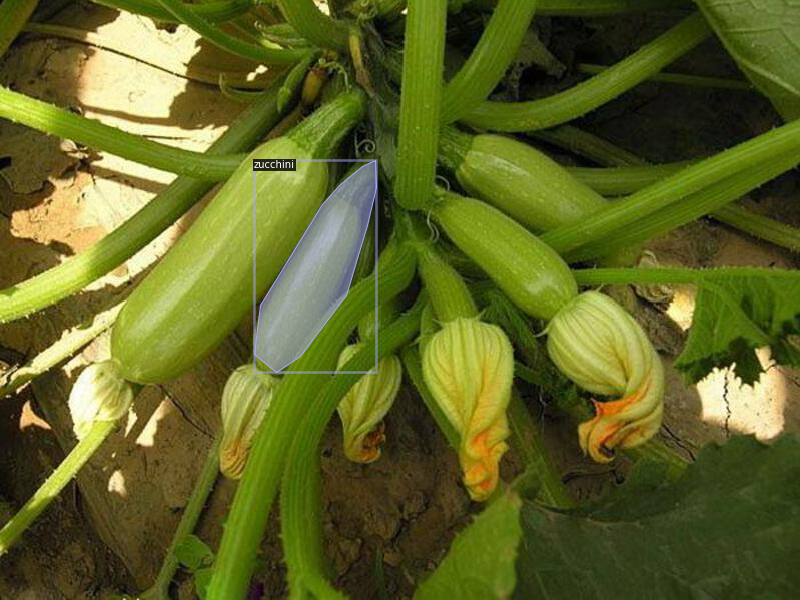

In [ ]:
zucchini_metadata = MetadataCatalog.get("zucchini_train")
dataset_dicts = get_zucchini_dicts("zucchini/images_via/train")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zucchini_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("zucchini_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR  0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
# Show the final model
!ls output -al
!zip -r output.zip output

total 342928
drwxr-xr-x 2 root root      4096 Mar 21 02:39 .
drwxr-xr-x 1 root root      4096 Mar 21 02:34 ..
-rw-r--r-- 1 root root     54420 Mar 21 02:39 events.out.tfevents.1616294060.2e5b5248ef1d.169.0
-rw-r--r-- 1 root root        15 Mar 21 02:39 last_checkpoint
-rw-r--r-- 1 root root     37656 Mar 21 02:39 metrics.json
-rw-r--r-- 1 root root 351036379 Mar 21 02:39 model_final.pth
  adding: output/ (stored 0%)
  adding: output/model_final.pth (deflated 7%)
  adding: output/events.out.tfevents.1616294060.2e5b5248ef1d.169.0 (deflated 71%)
  adding: output/metrics.json (deflated 76%)
  adding: output/last_checkpoint (stored 0%)


In [ ]:
from google.colab import files
files.download("output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
print(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
with open(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"), "r") as file1:
    FileContent = file1.read()
    print(FileContent)
    

In [ ]:
# print(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# with open(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"), "r") as file1:
#     FileContent = file1.read()
#     print(FileContent)

with open("/usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/Base-RCNN-FPN.yaml", "r") as file1:
    FileContent = file1.read()
    print(FileContent)

# print(cfg)

In [ ]:
print(model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
with open(model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"), "r") as file1:
    FileContent = file1.read()
    print(FileContent)

In [ ]:
# Clone models
!rm -r zucchini
!git clone --depth 1 https://github.com/fabriziogiordano/zucchini.git

rm: cannot remove 'zucchini': No such file or directory
Cloning into 'zucchini'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 113 (delta 10), reused 97 (delta 6), pack-reused 0
Receiving objects: 100% (113/113), 330.00 MiB | 37.71 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
#Comine models and prepare it
!cat zucchini/pretrained/model.* > zucchini/pretrained/model_final.zip
!unzip zucchini/pretrained/model_final.zip -d /content > /dev/null
!rm zucchini/pretrained/model*

In [ ]:
#!rm -rf output/
#!rm -rf output_or
# !ls -al /

In [ ]:
# NEW
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR  0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (0.7)   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


In [ ]:
#Original File

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (0.7)   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
print(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_zucchini_dicts("zucchini/images_via/test")
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata={}, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


NameError: ignored

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "balloon_val")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
from PIL import Image
import numpy as np
!pip install ipyplot --quiet
import ipyplot


basewidth = 500
def resize(img):
  image = Image.fromarray(np.uint8(img)).convert('RGB')
  wpercent = (basewidth/float(image.size[0]))
  hsize = int((float(image.size[1])*float(wpercent)))
  image = image.resize((basewidth,hsize), Image.ANTIALIAS)
  return image
  #cv2_imshow(np.array(image))

#!wget "https://www.thespruce.com/thmb/T31RYYlZn20l3DfVVzacljUaofY=/960x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/companion-plants-zucchini-and-summer-squash-2540045-09-56137aa52a9445dab3fd9f6613a36ed9.jpg" -q -O input.jpg
#!wget "https://l.hdnux.com/350x235p/s3-us-west-1.amazonaws.com/contentlab.studiod/getty/b38522002081438f9be2ff162006a252.jpg" -q -O input.jpg
!wget "https://www.piante.it/wp-content/uploads/Zucchina-pianta.jpg" -q -O input.jpg
#!wget "https://www.gardeningknowhow.com/wp-content/uploads/2016/02/zucchini-fertilizer.jpg" -q -O input.jpg
im = cv2.imread("./input.jpg")
im2 = resize(im[:, :, ::-1])

outputs = predictor(im)
# print(len(outputs["instances"]))
# print(outputs["instances"].get_fields())
v = Visualizer(im[:, :, ::-1], metadata={}, scale=1, instance_mode=ColorMode.IMAGE_BW)
img = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#cv2_imshow(img.get_image()[:, :, ::-1])

img_ai = resize(img.get_image())

ipyplot.plot_images([im2, img_ai], max_images=20, img_width=basewidth)




        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


AttributeError: ignored

In [ ]:
from PIL import Image
import numpy as np

results = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata={}, scale=1, instance_mode=ColorMode.IMAGE_BW)
img_ai = v.draw_instance_predictions(results["instances"].to("cpu")).get_image()
#cv2_imshow(img_ai[:, :, ::-1])

PIL_image1 = Image.fromarray(np.uint8(img_ai)).convert('RGB')
basewidth = 800
wpercent = (basewidth/float(PIL_image1.size[0]))
hsize = int((float(PIL_image1.size[1])*float(wpercent)))
img = PIL_image1.resize((basewidth,hsize), Image.ANTIALIAS)
cv2_imshow(np.array(img)[:, :, ::-1])

# PIL_image2 = Image.fromarray(img_ai.astype('uint8'), 'RGB')
# basewidth = 800
# wpercent = (basewidth/float(PIL_image2.size[0]))
# hsize = int((float(PIL_image2.size[1])*float(wpercent)))
# img2 = PIL_image2.resize((basewidth,hsize), Image.ANTIALIAS)
# cv2_imshow(np.array(img2)[:, :, ::-1])



AttributeError: ignored

<PIL.Image.Image image mode=RGB size=800x880 at 0x7FB2245CCF10>

### Function to draw masks

This function draws masks to the image. The binary NumPy masks consisting of `True/False` for each pixel value of the image are converted to `RGBA` image files.

In [ ]:
background_mask_window = (0, 247, 255, 100)
background_mask_building = (255, 167, 14, 100)

# masks = (outputs["instances"].get_fields()["pred_masks"].to("cpu").numpy())
# print(masks)

background_color = (255, 255, 255, 0)

# util method to convert the detectron2 box format
def xyxy_to_xywh(box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    w = x2-x1
    h = y2-y1
    return [x1,y1,w,h]

# Cut out masks
print("Extracting objects...")
#print(results['instances'])
#print(im.shape)
index = 0
for i in range(len(results['instances'].pred_masks)):
    im = cv2.imread("./input.jpg")
    im = cv2.cvtColor(im, cv2.COLOR_RGB2RGBA)
    mask_class = results['instances'].pred_classes[i]
    #print(mask_class)
    mask = results['instances'].pred_masks[i]
    #print(mask.shape)

    x=0
    y=0
    for line in mask:
        for column in line:
            if not column:
                im[x,y] = background_color
            y+=1
        y=0
        x+=1
    # Cropping image to the size of the objects bounding box
    box = results['instances'].pred_boxes[i]
    print(im.shape)
    print(box.tensor.cpu().numpy())
    box = box.tensor.cpu().numpy()[0]
    box = xyxy_to_xywh(box)
    

    radius = 2
    thickness = 2
    
    color = (255, 0, 0, 255)
    center_coordinates = (box[0],box[1])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (0, 255, 0, 255)
    center_coordinates = (box[0],box[1]+box[3])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (0, 0, 255, 255)
    center_coordinates = (box[0]+box[2],box[1])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)

    color = (100, 0, 255, 255)
    center_coordinates = (box[0]+box[2],box[1]+box[3])
    im = cv2.circle(im, center_coordinates, radius, color, thickness)


    im = im[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
    cv2_imshow(im)

print("Done...")



Extracting objects...
(450, 409, 4)
[[146.18759 230.51001 283.9504  430.22964]]


AttributeError: ignored

<PIL.Image.Image image mode=RGBA size=137x200 at 0x7FB22451BC10>

Done...


In [ ]:
#         # Check if class is in filter
#         if mask_class in class_filter:
#             # make everything transparent except the mask
#             mask = results['instances'][path].pred_masks[i]
#             img = cv2.imread(path)
#             img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
#             x=0
#             y=0
#             for line in mask:
#                 for column in line:
#                     if not column:
#                         img[x,y] = background_color
#                     y+=1
#                 y=0
#                 x+=1
                
#             # Cropping image to the size of the objects bounding box
#             box = results['instances'][path].pred_boxes[i]
#             box = box.tensor.numpy()[0]
#             box = xyxy_to_xywh(box)
#             img = img[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
            
    #         # Save image
    #         new_img_path = './masks/'+ mask_class+ "_" + str(index) + "_" + str(i) + ".png"
    #         cv2.imwrite(new_img_path,img)
    #         print("Removed background from '" + path+"'. Saved object in '" + new_img_path + "")
    # index+=1





    

# def draw_mask(img, mask, category):
#     """Draws a mask onto the image."""

#     img = img.convert("RGBA")
#     print(len(mask))
#     print(mask.shape)

#     mask_RGBA = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)

#     if category == 0:
#         mask_RGBA[mask] = background_mask_window
#     elif category == 1:
#         mask_RGBA[mask] = background_mask_building
#     mask_RGBA[~mask] = [0, 0, 0, 0]
#     rgb_image = Image.fromarray(mask_RGBA).convert("RGBA")

#     #img = Image.alpha_composite(img, rgb_image)
#     return rgb_image

# img = draw_mask(img, mask=masks[0], category=0)
# cv2_imshow(np.array(img)[:, :, ::-1])

# Run panoptic segmentation on a video

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

Upload image

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]))) 